We are going to vectorize the surnames, we will obtain a vector for each surname in the form of hot encoded with all characters 
of the Alphabet, because depending of the language, we may have characters that we are not aware of, therefore, we will use the
training dataset to form the vocabulary that will be used for the one-hot encoded vector.

In [1]:
import torch
import pandas as pd
import utils

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('train.csv')
validation = pd.read_csv('validation.csv')
test = pd.read_csv('test.csv')

In [3]:
dataset = utils.dataset_processing.create_vocabulary(train,validation,test)

In [4]:
dataset.transform_encoded_dataset()

In [5]:
len(dataset.nation_vocab)

18

##### Model

In [6]:
class Surname_classifier(nn.Module):
    def __init__(self,initial_num_channels, num_classes, num_channels):
        super(Surname_classifier,self).__init__()
        
        self.convnet = nn.Sequential(

            nn.Conv1d(in_channels = initial_num_channels, out_channels = num_channels, kernel_size = 4),
            nn.ELU(),

            nn.Conv1d(in_channels = num_channels, out_channels = num_channels, kernel_size = 3,stride=2),
            nn.ELU(),

            nn.Conv1d(in_channels = num_channels, out_channels = num_channels, kernel_size = 2, stride =1),
            nn.ELU(),

            nn.Conv1d(in_channels = num_channels, out_channels = num_channels, kernel_size = 3,stride=2),
            nn.ELU(),

            nn.Conv1d(in_channels = num_channels, out_channels = num_channels, kernel_size = 3, stride =2),
            nn.ELU(),

            nn.Conv1d(in_channels = num_channels, out_channels = num_channels, kernel_size = 3, stride =2),
            nn.ELU(),

            nn.Conv1d(in_channels = num_channels, out_channels = num_channels, kernel_size = 2, stride =1),
            nn.ELU(),


        )
        
        self.fc1 = nn.Linear(num_channels,140)
        self.fc2 = nn.Linear(140,80)
        self.fc3 = nn.Linear(80,num_classes)

        
    def forward(self,x_surname,apply_softmax=False):
        features = self.convnet(x_surname).squeeze(dim=2) # because that dimension is going to be size one 
        prediction_vector = self.fc1(F.dropout(features,p=0.5))
        prediction_vector = self.fc2(F.dropout(prediction_vector,p=0.5))
        prediction_vector = self.fc3(F.dropout(prediction_vector,p=0.5))
       
            
        if apply_softmax:
            prediction_vector = F.softmax(prediction_vector, dim=1)
            
        return prediction_vector

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Surname_classifier(dataset.max_sequence,len(dataset.nation_vocab),256).to(device)

##### Loss, Optimizer and Dataloader

In [8]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(params = model.parameters(), lr = 0.0001)
n_batch = 30
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# We create the datalader with the encoded train dataset and the ratings of the training dataset
loader = utils.data_loader_luis(dataset.train_surname_encoded,dataset.train_nation_encoded,n_batch)

In [9]:
import time
start_time = time.time()

epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
epoch: 20
epoch: 21
epoch: 22
epoch: 23
epoch: 24
epoch: 25
epoch: 26
epoch: 27
epoch: 28
epoch: 29
epoch: 30
epoch: 31
epoch: 32
epoch: 33
epoch: 34
epoch: 35
epoch: 36
epoch: 37
epoch: 38
epoch: 39
epoch: 40
epoch: 41
epoch: 42
epoch: 43
epoch: 44
epoch: 45
epoch: 46
epoch: 47
epoch: 48
epoch: 49
epoch: 50
epoch: 51
epoch: 52
epoch: 53
epoch: 54
epoch: 55
epoch: 56
epoch: 57
epoch: 58
epoch: 59
epoch: 60
epoch: 61
epoch: 62
epoch: 63
epoch: 64
epoch: 65
epoch: 66
epoch: 67
epoch: 68
epoch: 69
epoch: 70
epoch: 71
epoch: 72
epoch: 73
epoch: 74
epoch: 75
epoch: 76
epoch: 77
epoch: 78
epoch: 79
epoch: 80
epoch: 81
epoch: 82
epoch: 83
epoch: 84
epoch: 85
epoch: 86
epoch: 87
epoch: 88
epoch: 89
epoch: 90
epoch: 91
epoch: 92
epoch: 93
epoch: 94
epoch: 95
epoch: 96
epoch: 97
epoch: 98
epoch: 99
epoch: 100

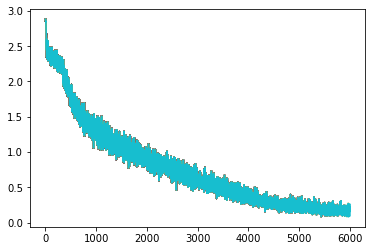

In [10]:
n_epochs = 200
error = []
error_validation = []
model.train()

for epoch_i in range(n_epochs):
    print('epoch: ' + str(epoch_i))
    for batch_i in range(n_batch):
    
        # Step 0: Generate the data for training
        x_data, targets = loader.batch()
        
        
        # Step 1: set up all the gradients in the model to zero, in order to avoid the accumulation of  
        # the gradients in each iteration
        model.zero_grad()
        
        
        # Step 2: compute the forward pass of the model
        y_pred = model(x_data.to(device))
        #y_pred_validation = model(dataset.validation_surname_encoded.float().to(device))
        
        # Step 3: Compute the loss value that we wish to optimize
        loss = loss_function(y_pred,targets.long().to(device))
        #loss_validation = loss_function(y_pred_validation,torch.Tensor(dataset.validation_nation_encoded).long().to(device))

                                        
        error.append(loss.to(torch.device('cpu')))
        #error_validation.append(loss_validation.to(torch.device('cpu')))
        torch.cuda.empty_cache()
        
        # Step 4: Propagate the loss signal backwards
        loss.backward()
        
        
        # Step 5: Trigger the optimizer to perfomr the update
        optimizer.step()
        
        
        
    plt.plot(error)


In [11]:
finish_time = time.time()
print(finish_time - start_time)

716.2501757144928


Surname_classifier(
  (convnet): Sequential(
    (0): Conv1d(16, 256, kernel_size=(4,), stride=(1,))
    (1): ELU(alpha=1.0)
    (2): Conv1d(256, 256, kernel_size=(3,), stride=(2,))
    (3): ELU(alpha=1.0)
    (4): Conv1d(256, 256, kernel_size=(2,), stride=(1,))
    (5): ELU(alpha=1.0)
    (6): Conv1d(256, 256, kernel_size=(3,), stride=(2,))
    (7): ELU(alpha=1.0)
    (8): Conv1d(256, 256, kernel_size=(3,), stride=(2,))
    (9): ELU(alpha=1.0)
    (10): Conv1d(256, 256, kernel_size=(3,), stride=(2,))
    (11): ELU(alpha=1.0)
    (12): Conv1d(256, 256, kernel_size=(2,), stride=(1,))
    (13): ELU(alpha=1.0)
  )
  (fc1): Linear(in_features=256, out_features=140, bias=True)
  (fc2): Linear(in_features=140, out_features=80, bias=True)
  (fc3): Linear(in_features=80, out_features=18, bias=True)
)

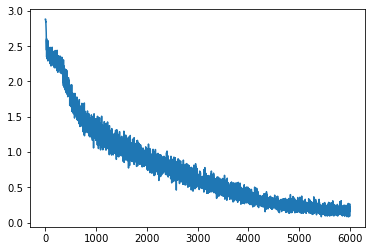

In [12]:
plt.plot(error)
plt.plot(error_validation)
model.eval()

In [13]:
torch.cuda.empty_cache()
device = torch.device('cpu')

model = model.to(device)

In [14]:
y_pred_training = model(dataset.train_surname_encoded.float().to(device))

In [15]:
utils.accuracy(y_pred_training,dataset.train_nation_encoded)

0.9501302083333333

In [16]:
y_pred_validation = model(dataset.validation_surname_encoded.float().to(device))

In [17]:
utils.accuracy(y_pred_validation,dataset.validation_nation_encoded)

0.7012048192771084

In [18]:
y_pred_test = model(dataset.test_surname_encoded.float().to(device))

In [19]:
utils.accuracy(y_pred_test,dataset.test_nation_encoded)

0.699390243902439

### Evaluation

In [20]:
labels = list(dataset.nation_vocab.to_serializable()['token_to_idx'])

##### Confusion matrix of the validation set

In [21]:
utils.counfusion_matrix(labels,utils.classifier(y_pred_validation),dataset.validation_nation_encoded)

,Arabic,Chinese,Czech,Dutch,English,French,German,Greek,Irish,Italian,Japanese,Korean,Polish,Portuguese,Russian,Scottish,Spanish,Vietnamese
Arabic,237,0,0,0,0,0,0,0,1,0,3,0,0,0,0,0,0,0
Chinese,0,25,0,0,2,0,1,0,0,1,1,3,0,0,0,0,0,0
Czech,0,0,21,2,11,0,6,0,1,2,2,1,5,0,10,1,1,0
Dutch,0,0,2,13,5,3,7,1,1,0,1,0,0,0,2,0,1,0
English,6,4,11,15,309,13,32,5,12,10,3,0,1,0,15,3,7,1
French,0,0,2,0,19,7,3,0,1,2,1,0,0,0,0,0,0,0
German,0,1,3,2,19,2,42,0,1,3,1,1,0,0,9,0,2,1
Greek,0,0,0,3,0,1,0,14,0,1,1,0,0,1,3,0,0,0
Irish,0,1,0,0,16,0,2,0,9,0,0,0,0,0,0,0,0,0
Italian,0,1,1,1,4,1,1,1,2,62,2,0,0,0,6,0,8,0


##### Confusion matrix of the test set

In [22]:
utils.counfusion_matrix(labels,utils.classifier(y_pred_test),dataset.test_nation_encoded)

,Arabic,Chinese,Czech,Dutch,English,French,German,Greek,Irish,Italian,Japanese,Korean,Polish,Portuguese,Russian,Scottish,Spanish,Vietnamese
Arabic,240,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Chinese,0,19,1,0,3,0,0,0,0,1,2,1,0,0,1,0,0,5
Czech,0,0,18,1,12,1,9,0,0,2,3,0,1,0,13,0,2,0
Dutch,0,1,1,14,10,0,4,1,0,0,0,0,0,0,3,1,0,0
English,4,2,11,11,319,6,22,3,6,9,4,0,2,0,30,9,4,3
French,0,0,0,1,13,8,4,0,0,3,0,0,1,0,2,0,2,0
German,1,2,3,5,24,2,33,0,2,1,2,1,2,0,5,1,2,0
Greek,0,0,0,0,3,1,0,13,0,2,0,0,0,0,4,0,0,0
Irish,0,0,0,0,14,0,1,0,6,1,0,1,0,0,3,1,0,0
Italian,1,0,1,1,4,0,0,2,1,67,2,0,0,0,2,0,9,0
